In [13]:
!pip install opencv-python
!pip install tensorflow
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model,load_model,Sequential
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import h5py
from sklearn.metrics import classification_report,ConfusionMatrixDisplay

In [14]:
from tensorflow.keras.applications import ResNet50,Xception,vgg16

In [15]:
from tensorflow.keras.layers import Dropout,BatchNormalization,GlobalAveragePooling2D,AveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping

In [16]:
def load_normal(norm_path):
    norm_files = np.array(os.listdir(norm_path))
    norm_labels = np.array(['normal']*len(norm_files))
    norm_images = []
    for images in tqdm(norm_files):
        image = cv2.imread(norm_path + '/' + images)
        image = cv2.resize(image, dsize=(100,100))
        image = cv2.cvtColor(image,cv2.COLOR_BGR2LAB)
        l,a,b = cv2.split(image)
        clahe = cv2.createCLAHE(clipLimit=3.0,tileGridSize=(8,8))
        clahe_img = clahe.apply(l)
        upd_img = cv2.merge((clahe_img,a,b))
        clahe_img_new = cv2.cvtColor(upd_img,cv2.COLOR_LAB2BGR)
        norm_images.append(clahe_img_new)
    norm_images = np.array(norm_images)
    return norm_images, norm_labels

In [17]:
def load_covid(cov_path):
    cov_files = np.array(os.listdir(cov_path))
    cov_labels = np.array(['covid']*len(cov_files))
    cov_images = []
    for image in tqdm(cov_files):
        image = cv2.imread(cov_path +  '/' + image)
        image = cv2.resize(image, dsize=(100,100))
        image = cv2.cvtColor(image,cv2.COLOR_BGR2LAB)
        l,a,b = cv2.split(image)
        clahe = cv2.createCLAHE(clipLimit=3.0,tileGridSize=(8,8))
        clahe_img = clahe.apply(l)
        upd_img = cv2.merge((clahe_img,a,b))
        clahe_img_new = cv2.cvtColor(upd_img,cv2.COLOR_LAB2BGR)
        cov_images.append(clahe_img_new)
    cov_images = np.array(cov_images)
    return cov_images, cov_labels

In [18]:
def load_noncov(noncov_path):
    noncov_files = np.array(os.listdir(noncov_path))
    noncov_labels = np.array([noncov_file.split()[0].lower() for noncov_file in noncov_files])
    noncov_images = []
    for image in tqdm(noncov_files):
        image = cv2.imread(noncov_path +  '/' + image)
        image = cv2.resize(image, dsize=(100,100))
        image = cv2.cvtColor(image,cv2.COLOR_BGR2LAB)
        l,a,b = cv2.split(image)
        clahe = cv2.createCLAHE(clipLimit=3.0,tileGridSize=(8,8))
        clahe_img = clahe.apply(l)
        upd_img = cv2.merge((clahe_img,a,b))
        clahe_img_new = cv2.cvtColor(upd_img,cv2.COLOR_LAB2BGR)
        noncov_images.append(clahe_img_new)
    noncov_images = np.array(noncov_images)
    return noncov_images, noncov_labels

In [29]:
norm_images,norm_label=load_normal('C:/Users/imdin/OneDrive/Documents/My Games/COVID-19_Radiography_Dataset/Normal/images_trainsmall')

100%|██████████| 1035/1035 [00:02<00:00, 396.48it/s]


In [30]:
cov_images,cov_lables = load_covid('C:/Users/imdin/OneDrive/Documents/My Games/COVID-19_Radiography_Dataset/COVID/images_trainsmall')

100%|██████████| 1026/1026 [00:02<00:00, 510.30it/s]


In [31]:
noncov_images,noncov_labels = load_noncov('C:/Users/imdin/OneDrive/Documents/My Games/COVID-19_Radiography_Dataset/NONCOVID/images_trainsmall')

100%|██████████| 1008/1008 [00:02<00:00, 497.79it/s]


In [32]:
X_train = np.append(norm_images,cov_images,axis=0)

In [33]:
X_train = np.append(X_train,noncov_images,axis=0)

In [34]:
y_train = np.append(norm_label,cov_lables)

In [35]:
y_train = np.append(y_train,noncov_labels)

In [36]:
print(y_train.shape)
X_train.shape

(3069,)


(3069, 100, 100, 3)

In [37]:
print(np.unique(y_train, return_counts=True))

(array(['covid', 'noncovid', 'normal'], dtype='<U8'), array([1026, 1008, 1035], dtype=int64))


Displaying images


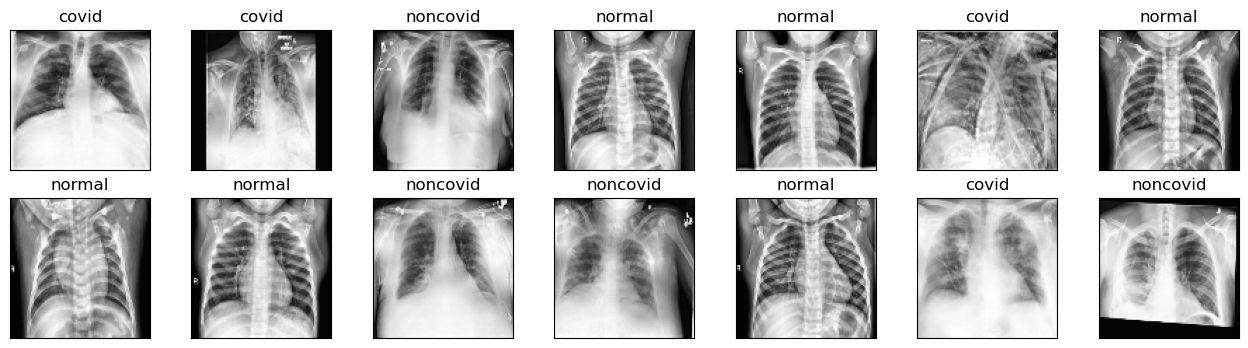

In [20]:
print('Displaying images')
fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(16, 4))
indices = np.random.choice(len(X_train), 14)
counter = 0
for i in range(2):
    for j in range(7):
        axes[i,j].set_title(y_train[indices[counter]])
        axes[i,j].imshow(X_train[indices[counter]], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        counter += 1
plt.show()

In [39]:
covid_test,testcov_labels = load_covid('C:/Users/imdin/OneDrive/Documents/My Games/COVID-19_Radiography_Dataset/COVID/images_testsmall')

100%|██████████| 405/405 [00:04<00:00, 100.78it/s]


In [40]:
norm_test,testnorm_labels = load_normal('C:/Users/imdin/OneDrive/Documents/My Games/COVID-19_Radiography_Dataset/Normal/images_testsmall')

100%|██████████| 432/432 [00:04<00:00, 103.89it/s]


In [41]:
noncov_test,testnoncov_labels = load_noncov('C:/Users/imdin/OneDrive/Documents/My Games/COVID-19_Radiography_Dataset/NONCOVID/images_testsmall')

100%|██████████| 414/414 [00:04<00:00, 100.36it/s]


In [42]:
X_test = np.append(norm_test,covid_test,axis=0)

In [43]:
X_test = np.append(X_test,noncov_test,axis=0)

In [44]:
y_test = np.append(testnorm_labels,testcov_labels)

In [45]:
y_test = np.append(y_test,testnoncov_labels)

In [46]:
y_test.shape
X_test.shape

(1251, 100, 100, 3)

In [47]:
noncov_Val,Valnoncov_labels = load_noncov('C:/Users/imdin/OneDrive/Documents/My Games/COVID-19_Radiography_Dataset/NONCOVID/images_val')

100%|██████████| 306/306 [00:02<00:00, 114.07it/s]


In [48]:
norm_Val,Val_labels = load_normal('C:/Users/imdin/OneDrive/Documents/My Games/COVID-19_Radiography_Dataset/Normal/images_val')

100%|██████████| 544/544 [00:05<00:00, 107.11it/s]


In [49]:
covid_Val,Valcov_labels = load_covid('C:/Users/imdin/OneDrive/Documents/My Games/COVID-19_Radiography_Dataset/COVID/images_val')

100%|██████████| 196/196 [00:01<00:00, 101.45it/s]


In [50]:
X_val = np.append(norm_Val,covid_Val,axis=0)

In [51]:
X_val = np.append(X_val,noncov_Val,axis=0)

In [52]:
y_val = np.append(Val_labels,Valcov_labels)

In [53]:
y_val = np.append(y_val,Valnoncov_labels)

In [54]:
y_train_new = y_train[:, np.newaxis]
y_test_new = y_test[:, np.newaxis]
y_val_new = y_val[:,np.newaxis]

In [55]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 3)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 3)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1],X_val.shape[2],3)
X_val.shape

(1046, 100, 100, 3)

In [56]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_train_one_hot = one_hot_encoder.fit_transform(y_train_new)
y_test_one_hot = one_hot_encoder.transform(y_test_new)
y_val_one_hot = one_hot_encoder.transform(y_val_new)
y_val_one_hot.shape

(1046, 3)

In [57]:
uniqs = np.unique(y_train)
uniq = uniqs.reshape(-1,1)

print(uniq)

newarr = one_hot_encoder.fit_transform(uniq)
newarr

[['covid']
 ['noncovid']
 ['normal']]


array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [58]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))
print(np.unique(y_val, return_counts=True))

(array(['covid', 'noncovid', 'normal'], dtype='<U8'), array([1026, 1008, 1035], dtype=int64))
(array(['covid', 'noncovid', 'normal'], dtype='<U8'), array([405, 414, 432], dtype=int64))
(array(['covid', 'noncovid', 'normal'], dtype='<U8'), array([196, 306, 544], dtype=int64))


In [59]:
print(X_train.shape)
print(y_train_one_hot.shape)

(3069, 100, 100, 3)
(3069, 3)


In [60]:
print(X_test.shape,y_test_one_hot.shape)

(1251, 100, 100, 3) (1251, 3)


In [61]:
print(X_val.shape,y_val_one_hot.shape)

(1046, 100, 100, 3) (1046, 3)


In [62]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Parameters
batch_size = 64  # Adjust as per your GPU capacity
epochs = 100  # You may want to adjust this based on when convergence happens
size = 100  # The images' width and height
n_classes = 3  # You have 'covid', 'noncovid', and 'normal' classes
n_ch = 3  # Number of color channels, assuming RGB

# Define the VGG16 model
def build_vgg16():
    base_model = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(size, size, n_ch)))
    x = base_model.output
    x = Flatten()(x)  # Flatten the output layer to 1 dimension
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)  # Dropout for regularization
    predictions = Dense(n_classes, activation='softmax')(x)  # Final prediction layer
    
    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # First: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Instantiate the model
model_vgg16 = build_vgg16()

# Summary of the model
model_vgg16.summary()

# Continue with the preparation of your datasets and the training process


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,076,035 (65.14 MB)

 Trainable params: 2,361,347 (9.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [63]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Parameters
batch_size = 64
epochs = 100
size = 100  # Assuming your images are 100 x 100
n_classes = 3  # You have 'covid', 'noncovid', and 'normal' classes
n_ch = 3  # Assuming color images (RGB)

# Define the VGG16 model
def build_vgg16():
    base_model = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(size, size, n_ch)))
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False  # Freeze the layers not to train the pre-trained weights
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Instantiate the model
model_vgg16 = build_vgg16()

# Model callbacks
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.7, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('vgg16_Model.keras', monitor='val_accuracy', verbose=1, save_best_only=True)


# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=360,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

# Fit the data generator to your training data
datagen.fit(X_train)

# Now you can train your model using the fit method, datagen.flow(), and the callbacks
history_vgg16 = model_vgg16.fit(
    datagen.flow(X_train, y_train_one_hot, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=(X_val, y_val_one_hot),
    epochs=epochs,
    callbacks=[annealer, checkpoint],
    verbose=1
)


Epoch 1/100


C:\Users\imdin\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.5219 - loss: 11.3003
Epoch 1: val_accuracy improved from -inf to 0.34704, saving model to vgg16_Model.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 39s 790ms/step - accuracy: 0.5238 - loss: 11.2376 - val_accuracy: 0.3470 - val_loss: 20.3904 - learning_rate: 1.0000e-04
Epoch 2/100
 1/47 ━━━━━━━━━━━━━━━━━━━━ 29s 631ms/step - accuracy: 0.6094 - loss: 7.1654

C:\Users\imdin\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy did not improve from 0.34704
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - accuracy: 0.6094 - loss: 3.6589 - val_accuracy: 0.3461 - val_loss: 20.8776 - learning_rate: 1.0000e-04
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.6951 - loss: 5.2958
Epoch 3: val_accuracy did not improve from 0.34704
47/47 ━━━━━━━━━━━━━━━━━━━━ 37s 771ms/step - accuracy: 0.6953 - loss: 5.2892 - val_accuracy: 0.3470 - val_loss: 18.0104 - learning_rate: 1.0000e-04
Epoch 4/100
 1/47 ━━━━━━━━━━━━━━━━━━━━ 26s 582ms/step - accuracy: 0.7188 - loss: 3.4898
Epoch 4: val_accuracy improved from 0.34704 to 0.35660, saving model to vgg16_Model.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 207ms/step - accuracy: 0.7188 - loss: 1.7820 - val_accuracy: 0.3566 - val_loss: 17.3448 - learning_rate: 1.0000e-04
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.7247 - loss: 3.9289
Epoch 5: val_accuracy did not improve from 0.35660
47/47 ━━━━━━━━━━━━━━━━━━━━ 37s 777ms/step - accuracy:

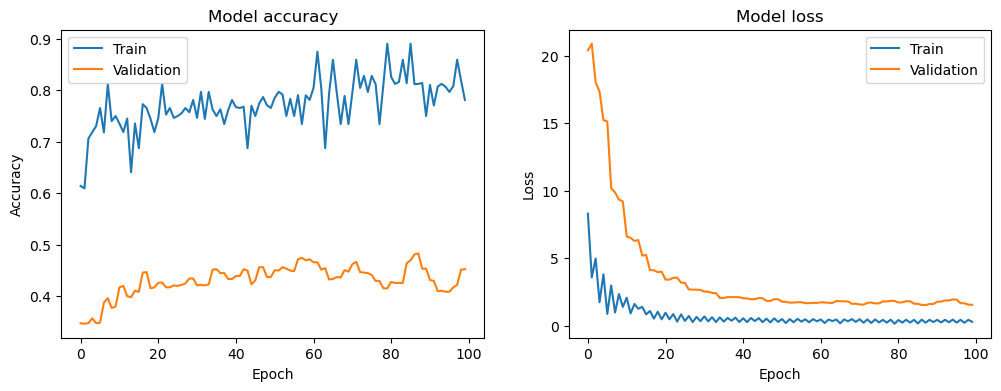

In [64]:
import matplotlib.pyplot as plt

# Assuming 'history_vgg16' is the output from the 'fit' method used during training
acc = history_vgg16.history['accuracy']
val_acc = history_vgg16.history['val_accuracy']
loss = history_vgg16.history['loss']
val_loss = history_vgg16.history['val_loss']

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train')
plt.plot(val_acc, label='Validation')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [65]:
# Evaluate the model on the validation set
score_val = model_vgg16.evaluate(X_val, y_val_one_hot, verbose=1)
print('Validation Loss:', score_val[0])
print('Validation Accuracy:', score_val[1]*100)

# Load the best model weights
model_vgg16.load_weights("vgg16_Model.keras")

# Evaluate the model on the test set
score_test = model_vgg16.evaluate(X_test, y_test_one_hot, verbose=1)
print('Test Loss:', score_test[0])
print('Test Accuracy:', score_test[1]*100)


33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 268ms/step - accuracy: 0.2542 - loss: 2.2879
Validation Loss: 1.5576488971710205
Validation Accuracy: 45.219886302948
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 260ms/step - accuracy: 0.3433 - loss: 1.9050
Test Loss: 1.1961108446121216
Test Accuracy: 54.67625856399536


In [67]:
predictions = model_vgg16.predict(X_test)
print(predictions)

40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 264ms/step
[[4.0257511e-01 5.7611603e-01 2.1308837e-02]
 [1.9520734e-01 4.5802435e-01 3.4676835e-01]
 [3.1605092e-01 3.6036953e-01 3.2357955e-01]
 ...
 [5.6901997e-01 4.1663724e-01 1.4342755e-02]
 [2.9640648e-01 5.4052198e-01 1.6307150e-01]
 [2.1225207e-02 9.7838610e-01 3.8868119e-04]]


In [68]:
predictions = one_hot_encoder.inverse_transform(predictions)
# print('Model evaluation')
print(one_hot_encoder.categories_)

[array(['covid', 'noncovid', 'normal'], dtype='<U8')]


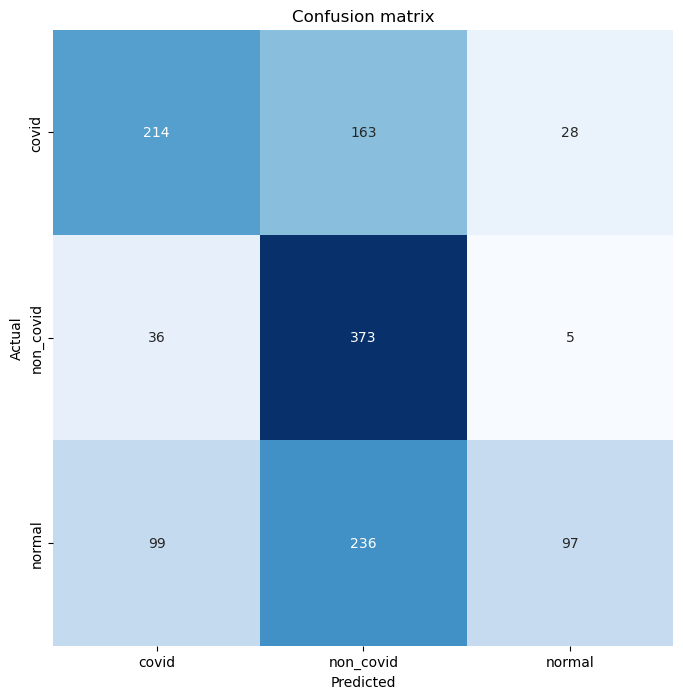

In [69]:
classnames = ['covid', 'non_covid', 'normal']
# Display confusion matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8,8))
plt.title('Confusion matrix')
sns.heatmap(cm, cbar=False, xticklabels=classnames, yticklabels=classnames, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [70]:
report = classification_report(y_test, predictions, target_names=['covid', 'non_covid', 'normal'])

print(report)

              precision    recall  f1-score   support

       covid       0.61      0.53      0.57       405
   non_covid       0.48      0.90      0.63       414
      normal       0.75      0.22      0.35       432

    accuracy                           0.55      1251
   macro avg       0.61      0.55      0.51      1251
weighted avg       0.62      0.55      0.51      1251

